<h1>Movie Genius!</h1>

<h3>Load Raw Data

In [14]:
import pandas as pd
import json
import matplotlib.pyplot as plt

#link => https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata
movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

In [15]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [16]:
credits.head(1)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


<h3>Data preprocessing

In [17]:
from datetime import datetime

# Convert release date to datetime and calculate movie age
movies['release_date'] = pd.to_datetime(movies['release_date'])
current_date = datetime.now()
movies['movie_age'] = movies['release_date'].apply(lambda x: (current_date - x).days)

#add column for movie budget and popularity interaction
movies['budget_popularity_interaction'] = movies['budget'] * movies['popularity']
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_age,budget_popularity_interaction
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,5114.0,3.565371e+10


In [18]:
# Helper function to extract names from JSON arrays
def extract_names(json_array):
    return [item['name'] for item in json.loads(json_array)]

# Parsing 'genres' and 'keywords'
movies['genres'] = movies['genres'].apply(extract_names)
movies['keywords'] = movies['keywords'].apply(extract_names)

# Parsing 'cast' - extracting the top 3 actors
def extract_top_cast(cast_json, top_n=3):
    cast = json.loads(cast_json)
    return [actor['name'] for actor in cast[:top_n]]

credits['cast'] = credits['cast'].apply(extract_top_cast)

# Parsing 'crew' to find the director
def find_director(crew_json):
    crew = json.loads(crew_json)
    directors = [member['name'] for member in crew if member['job'] == 'Director']
    return directors[0] if directors else None

credits['crew'] = credits['crew'].apply(find_director)
credits.rename(columns={'crew': 'director'}, inplace=True)

# Merging movies and credits
movies = movies.merge(credits, left_on='id', right_on='movie_id', how='left')

# Selecting important columns
movies = movies[['original_title', 'genres', 'cast', 'director', 'keywords', 'budget', 'revenue', 'vote_count', 'vote_average', 'movie_age', 'budget_popularity_interaction']]


# Removing entries with missing data
movies.dropna(inplace=True)

In [19]:
movies.head(1)

,original_title,genres,cast,director,keywords,budget,revenue,vote_count,vote_average,movie_age,budget_popularity_interaction
0,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war, space colon...",237000000,2787965087,11800,7.2,5114.0,3.565371e+10


In [20]:
# One-Hot Encoding for 'genres'
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler

mlb = MultiLabelBinarizer()
scaler = StandardScaler()

movies_encoded = movies.dropna()
columns_to_process = ['genres', 'cast', 'keywords']
for column in columns_to_process:
    movies_encoded = movies_encoded.join(pd.DataFrame(mlb.fit_transform(movies_encoded.pop(column)),
                                      columns=[f"{column}_{class_}" for class_ in mlb.classes_],
                                      index=movies_encoded.index))
# One-Hot Encoding for 'director'
director_encoded_df = pd.get_dummies(movies['director'], prefix='director')

# Joining the encoded dataframes back to the main dataframe
movies_encoded = movies_encoded.join(director_encoded_df)
movies_encoded.drop('director', axis=1, inplace=True)
movies_encoded[['budget', 'revenue']] = scaler.fit_transform(movies[['budget', 'revenue']])
movies_encoded.head(1)

,original_title,budget,revenue,vote_count,vote_average,movie_age,budget_popularity_interaction,genres_Action,genres_Adventure,genres_Animation,...,director_Zackary Adler,director_Zak Penn,director_Zal Batmanglij,director_Zhang Yimou,director_Zoran Lisinac,director_Àlex Pastor,director_Álex de la Iglesia,director_Émile Gaudreault,director_Éric Tessier,director_Étienne Faure
0,Avatar,5.094717,16.573842,11800,7.2,5114.0,3.565371e+10,1,1,0,...,False,False,False,False,False,False,False,False,False,False


<h3>Data visualization

<h3>Feature Exraction

<h3>Splitting into train and test sets

In [51]:
from sklearn.model_selection import train_test_split

y = movies_encoded['vote_average']
X = movies_encoded.drop(columns = ['vote_average', 'original_title'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print(X_train.dtypes)
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Training set shape: (2863, 17859)
Test set shape: (1910, 17859)
budget                           float64
revenue                          float64
vote_count                         int64
movie_age                        float64
budget_popularity_interaction    float64
                                  ...   
director_Àlex Pastor                bool
director_Álex de la Iglesia         bool
director_Émile Gaudreault           bool
director_Éric Tessier               bool
director_Étienne Faure              bool
Length: 17859, dtype: object


In [22]:
y.head(1)

0    7.2
Name: vote_average, dtype: float64

In [23]:
X.head(1)

,budget,revenue,vote_count,movie_age,budget_popularity_interaction,genres_Action,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,...,director_Zackary Adler,director_Zak Penn,director_Zal Batmanglij,director_Zhang Yimou,director_Zoran Lisinac,director_Àlex Pastor,director_Álex de la Iglesia,director_Émile Gaudreault,director_Éric Tessier,director_Étienne Faure
0,5.094717,16.573842,11800,5114.0,3.565371e+10,1,1,0,0,0,...,False,False,False,False,False,False,False,False,False,False


<h3>Supervised Learning

<h4>For movie recommendations with KNN

In [52]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(X_train)

def recommend_movies(x=0):
    # Get the top 10 nearest neighbors for the movie
    distances, indices = model_knn.kneighbors(X_train[x, :].reshape(1, -1), n_neighbors = 11)
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print(f"Recommendations for {movies_encoded['original_title'].iloc[x]}:\n")
        else:
            print(f"{i}: {movies_encoded['original_title'].iloc[indices.flatten()[i]]}, with distance of {round(distances.flatten()[i], 7)}")

recommend_movies()

Recommendations for Avatar:

1: Crimson Tide, with distance of 0.756572
2: Small Soldiers, with distance of 0.8084406
3: Dragonfly, with distance of 0.8172075
4: The Conjuring 2, with distance of 0.873548
5: Finding Neverland, with distance of 0.875724
6: Delivery Man, with distance of 0.8804447
7: In the Valley of Elah, with distance of 0.8933089
8: Monkeybone, with distance of 0.9089026
9: Casino Royale, with distance of 0.915816
10: Mighty Joe Young, with distance of 0.933748


<h3>For rating prediction

Import all machine learning tools and functions required

In [53]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#predict a movie rating
def predict_rating(i=123, model = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train), y_test = y_test):
    # Predict the response for test dataset
    y_pred = model.predict(X_test)
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    # Extract the features for the specified index
    movie_features = X_test[i, :].reshape(1, -1)
    predicted_rating = model.predict(movie_features)
    actual_rating = movies_encoded['vote_average'][i]
    #print(f"For {model}:")
    return {movies_encoded['original_title'][i]: [f'{predicted_rating[0]:.2f}', f'{actual_rating:.2f}', f'{mse:.2f}', f'{mae:.2f}']}
    
    print(f"\nPredicted rating for the movie {movies_encoded['original_title'][i]} is {predicted_rating[0]:.2f}")
    print(f"Actual Rating for the movie {movies_encoded['original_title'][i]} is {actual_rating:.2f}")
    print(f'\nWith a mean squared error of {mse:.2f} and mean absolute error of {mae:.2f}')

In [43]:
#knn
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

i = 0
movie_rating_results_knn = {}
while i < 500:
    movie_rating_results_knn.update(predict_rating(i = i, model=knn))
    i +=1
movie_rating_results_knn

{'Avatar': ['5.46', '7.20', '1.86', '1.09'],
 "Pirates of the Caribbean: At World's End": ['5.46', '6.90', '1.86', '1.09'],
 'Spectre': ['5.46', '6.30', '1.86', '1.09'],
 'The Dark Knight Rises': ['5.46', '7.60', '1.86', '1.09'],
 'John Carter': ['5.46', '6.10', '1.86', '1.09'],
 'Spider-Man 3': ['5.46', '5.90', '1.86', '1.09'],
 'Tangled': ['5.46', '7.40', '1.86', '1.09'],
 'Avengers: Age of Ultron': ['5.46', '7.30', '1.86', '1.09'],
 'Harry Potter and the Half-Blood Prince': ['5.36', '7.40', '1.86', '1.09'],
 'Batman v Superman: Dawn of Justice': ['5.46', '5.70', '1.86', '1.09'],
 'Superman Returns': ['5.46', '5.40', '1.86', '1.09'],
 'Quantum of Solace': ['5.46', '6.10', '1.86', '1.09'],
 "Pirates of the Caribbean: Dead Man's Chest": ['5.46',
  '7.00',
  '1.86',
  '1.09'],
 'The Lone Ranger': ['5.46', '5.90', '1.86', '1.09'],
 'Man of Steel': ['5.46', '6.50', '1.86', '1.09'],
 'The Chronicles of Narnia: Prince Caspian': ['5.46', '6.30', '1.86', '1.09'],
 'The Avengers': ['5.46', '7.

For KNN

For Random forest

In [55]:
#rf_regressor
rf_regressor = RandomForestRegressor(n_estimators=50)
rf_regressor.fit(X_train, y_train)
i = 0
movie_rating_results = {}
while i < 300:
    movie_rating_results.update(predict_rating(i = i, model=rf_regressor))
    i +=1
movie_rating_results
# movie name : [predicted_rating, actual_rating, mse, mae]

{'Avatar': ['6.35', '7.20', '0.51', '0.52'],
 "Pirates of the Caribbean: At World's End": ['5.85', '6.90', '0.51', '0.52'],
 'Spectre': ['6.49', '6.30', '0.51', '0.52'],
 'The Dark Knight Rises': ['6.74', '7.60', '0.51', '0.52'],
 'John Carter': ['6.36', '6.10', '0.51', '0.52'],
 'Spider-Man 3': ['7.14', '5.90', '0.51', '0.52'],
 'Tangled': ['5.78', '7.40', '0.51', '0.52'],
 'Avengers: Age of Ultron': ['5.81', '7.30', '0.51', '0.52'],
 'Harry Potter and the Half-Blood Prince': ['7.73', '7.40', '0.51', '0.52'],
 'Batman v Superman: Dawn of Justice': ['5.90', '5.70', '0.51', '0.52'],
 'Superman Returns': ['6.33', '5.40', '0.51', '0.52'],
 'Quantum of Solace': ['5.70', '6.10', '0.51', '0.52'],
 "Pirates of the Caribbean: Dead Man's Chest": ['6.16',
  '7.00',
  '0.51',
  '0.52'],
 'The Lone Ranger': ['5.53', '5.90', '0.51', '0.52'],
 'Man of Steel': ['5.95', '6.50', '0.51', '0.52'],
 'The Chronicles of Narnia: Prince Caspian': ['6.07', '6.30', '0.51', '0.52'],
 'The Avengers': ['6.84', '7.

In [49]:
movie_rating_results = {}

for movie in movie_rating_results_knn:
    if movie in movie_rating_results_rf:
        movie_rating_results[movie] = [str((float(movie_rating_results_knn[movie][i]) + float(movie_rating_results_rf[movie][i])) / 2) for i in range(4)]

# Now combined_dict contains the averaged values
print(movie_rating_results)

{'Avatar': ['5.82', '7.2', '1.19', '0.81'], "Pirates of the Caribbean: At World's End": ['5.65', '6.9', '1.19', '0.81'], 'Spectre': ['5.955', '6.3', '1.19', '0.81'], 'The Dark Knight Rises': ['6.135', '7.6', '1.19', '0.81'], 'John Carter': ['5.9350000000000005', '6.1', '1.19', '0.81'], 'Spider-Man 3': ['6.32', '5.9', '1.19', '0.81'], 'Tangled': ['5.875', '7.4', '1.19', '0.81'], 'Avengers: Age of Ultron': ['5.795', '7.3', '1.19', '0.81'], 'Harry Potter and the Half-Blood Prince': ['6.4350000000000005', '7.4', '1.19', '0.81'], 'Batman v Superman: Dawn of Justice': ['5.615', '5.7', '1.19', '0.81'], 'Superman Returns': ['5.91', '5.4', '1.19', '0.81'], 'Quantum of Solace': ['5.48', '6.1', '1.19', '0.81'], "Pirates of the Caribbean: Dead Man's Chest": ['5.805', '7.0', '1.19', '0.81'], 'The Lone Ranger': ['5.55', '5.9', '1.19', '0.81'], 'Man of Steel': ['5.65', '6.5', '1.19', '0.81'], 'The Chronicles of Narnia: Prince Caspian': ['5.76', '6.3', '1.19', '0.81'], 'The Avengers': ['6.145', '7.4',

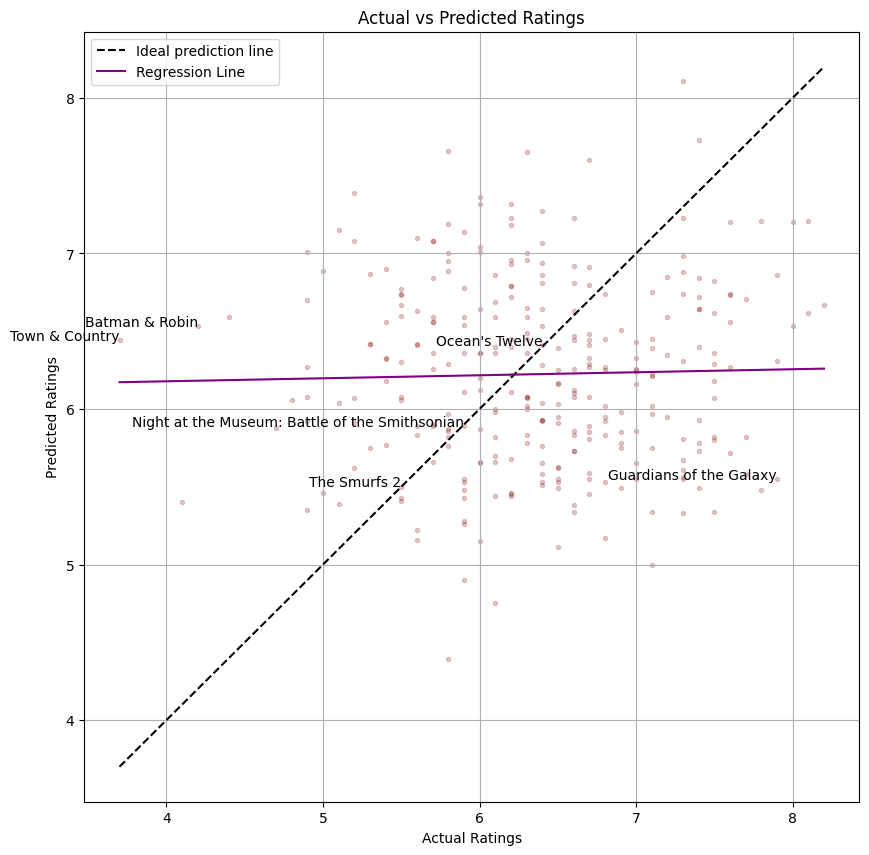

In [58]:

import numpy as np
# Preparing movie_rating_results for plotting
movies = list(movie_rating_results.keys())
predicted_ratings = [float(movie_rating_results[movie][0]) for movie in movies]
actual_ratings = [float(movie_rating_results[movie][1]) for movie in movies]

filtered_movies = []
filtered_predicted_ratings = []
filtered_actual_ratings = []
for movie, predicted, actual in zip(movies, predicted_ratings, actual_ratings):
    if predicted != 0:
        filtered_movies.append(movie)
        filtered_predicted_ratings.append(predicted)
        filtered_actual_ratings.append(actual)
movies = filtered_movies
predicted_ratings = filtered_predicted_ratings
actual_ratings = filtered_actual_ratings
line_x = np.linspace(min(actual_ratings), max(actual_ratings), 100)
slope, intercept = np.polyfit(actual_ratings, predicted_ratings, 1)
line_y = slope * line_x + intercept
# Creating the scatter plot
plt.figure(figsize=(10, 10))  # Adjust size as needed
plt.scatter(actual_ratings, predicted_ratings, alpha=0.2, color='maroon', marker = ".")

# Drawing the diagonal line (x=y line)
plt.plot([min(actual_ratings), max(actual_ratings)], [min(actual_ratings), max(actual_ratings)], color='black', linestyle='--', label='Ideal prediction line')
plt.plot(line_x, line_y, color='purple', label='Regression Line')

# Calculating rating differences to find outliers
rating_differences = [abs(p - a) for p, a in zip(predicted_ratings, actual_ratings)]
threshold_high = np.percentile(rating_differences, 99) 
threshold_low = np.percentile(rating_differences, 1)  

# Labeling outliers
for i, (x, y) in enumerate(zip(actual_ratings, predicted_ratings)):
    if abs(x - y) > threshold_high:
        plt.text(x, y, movies[i], fontsize=10, ha='right', color='black')
    if abs(x - y) < threshold_low:
        plt.text(x, y, movies[i], fontsize=10, ha='right', color='black')

# Customizing the plot
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings')
plt.grid(True)
plt.legend()
plt.show()

For SVM

In [ ]:
#svm_regressor
svm_regressor = SVR(kernel='linear')
svm_regressor.fit(X_train, y_train)

predict_rating(model=svm_regressor)

For Linear regression

In [ ]:
#linear_model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

predict_rating(model=linear_model)

For Ridge regression

In [ ]:
#ridge_model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

predict_rating(model=ridge_model)

For Lasso regression

In [ ]:
#lasso_model
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train, y_train)

predict_rating(model=lasso_model)

Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

models = {
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'SVM': SVR(kernel='linear'),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0)
}

# Perform k-fold cross-validation for each model
k_fold = KFold(n_splits=5, shuffle=True, random_state=1)

for model_name, model in models.items():
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=k_fold, scoring='neg_mean_squared_error')
    mse_cv = -cv_scores.mean()
    print(f'Cross-Validated MSE for {model_name}: {mse_cv:.2f}')


In [17]:
from sklearn.model_selection import cross_val_score
import numpy as np

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Predict the response for test dataset
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"For {model.__class__.__name__}:")
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'Mean Absolute Error: {mae:.2f}')

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f'Cross-Validated R-Squared: {np.mean(cv_scores):.2f}\n')

# Example usage:
models = [
    KNeighborsRegressor(n_neighbors=5),
    RandomForestRegressor(n_estimators=10),
    LinearRegression(),
    Ridge(alpha=1.0),
    Lasso(alpha=1.0),
    SVR(kernel='linear')
]
for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

For KNeighborsRegressor:
Mean Squared Error: 1.49
Mean Absolute Error: 0.87
Cross-Validated R-Squared: -0.05

For RandomForestRegressor:
Mean Squared Error: 0.55
Mean Absolute Error: 0.53
Cross-Validated R-Squared: 0.57

For LinearRegression:
Mean Squared Error: 1.23
Mean Absolute Error: 0.74
Cross-Validated R-Squared: 0.16

For Ridge:
Mean Squared Error: 1.23
Mean Absolute Error: 0.74
Cross-Validated R-Squared: 0.16

For Lasso:
Mean Squared Error: 1.47
Mean Absolute Error: 0.84
Cross-Validated R-Squared: -0.00



<h3>Unsupervised Learning</h3>

For K-means clustering

In [ ]:
#Kmeans clustering
from sklearn.cluster import KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=5, random_state=1)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original dataset
data_with_clusters = pd.concat([pd.DataFrame(X), pd.Series(cluster_labels, name='Cluster')], axis=1)
grouped_clusters = data_with_clusters.groupby('Cluster').mean()

print(grouped_clusters)

Graphical visualization

In [ ]:
import seaborn as sns

# Scatter plot for budget vs. revenue colored by cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x='revenue', y='budget', hue='Cluster', data=data_with_clusters, palette='viridis', hue_order=[0.0, 1.0, 2.0, 3.0, 4.0])
sns.regplot(x='revenue', y='budget', data=data_with_clusters, scatter=False, ci=None, color='orange')
plt.title('Scatter Plot: Budget vs. Revenue by Cluster')
plt.xlabel('Revenue')
plt.ylabel('Budget')
plt.show()